# Reproducing Hakim CDA Study (2019)
## Looking at Channels

In [1]:
import numpy as np
import glob
import pickle
import pandas as pd

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_brainvision

import sys
#sys.path.append('/Users/nick/Documents/PhD/Projects/CLCT/CDA-review/studies/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#sys.path.append('/Users/nick/Documents/PhD/Projects/CLCT/CDA-review/studies/Hakim-2019/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\Hakim-2019\\')
from events import get_specific_events
 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
study_id = 'Hakim2019'

triggers = dict();

triggers['2'] = [2, 3]
triggers['4'] = [4, 5]

triggers['left'] = [3, 5]   #[2, 4]
triggers['right'] = [2, 4]  #[3, 5]

triggers['good'] = [91]
triggers['bad'] = [90]

# Labels
conds = ['2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# Internal Triggers to Epochs Properly
internal_triggers = dict()
internal_triggers_count = 0
for cond in conds:
    for side in sides:
        for perf in perfs:
            internal_triggers_count = internal_triggers_count + 1
            internal_triggers['{}-{}-{}'.format(cond,side,perf)] = internal_triggers_count
            
# CDA Channels
chan_right = ['O2', 'PO4', 'PO8', 'P4', 'P8']
chan_left = ['O1', 'PO3', 'PO7', 'P3', 'P7']

# Epoch Information
epoch_length = 3.45
epoch_tmin = -0.4
baseline_corr = (-0.4, 0)

# CDA info
cda_window = (0.4, 1.45)

# CDA main variable!
cda_dict_all = dict()
epochs_dict_all = dict()
perf_report_all = dict()
report = prep_report(conds, sides, perfs)

In [3]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
experiences = ['Exp1a', 'Exp1b', 'Exp2a', 'Exp2b'] 

eegfiles = []
for cur_exp in experiences:
    #folderpath = '/Volumes/Nick - Data/CDA Datasets/Hakim 2019/{}/EEGData/**/*.vhdr'.format(cur_exp)
    folderpath = 'G:\\CDA Datasets\\Hakim 2019\\{}\\EEGData\\**\\*.vhdr'.format(cur_exp)
    for filepath in glob.glob(folderpath, recursive=True):
        eegfiles.append(filepath)

sep = '/'
for filepath in eegfiles:
    filename = filepath[filepath.rfind(sep)+1:]
    print('Processing: ' + filename + '...')
   
    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_brainvision(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Set Electrodes Locations - Used Brain Products (locations seem to in eeg file...)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    preproc = raw
    
    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = mne.events_from_annotations(preproc)
        
    # Select Channels (to save time on cleaning)
    #preproc = preproc.pick_channels(chan_right + chan_left)
    
    # Plot (visual check)
    #preproc.plot(events=events, block=True, lowpass=40)
    
    # ------------------------
    # 3. -- Epochs --
    # ------------------------    
    specific_events = get_specific_events(events[0], conds, sides, perfs, triggers, internal_triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr, clean=False)

    epochs_dict_all[filename] = epochs_dict
    
    # times, used for CDA mean amp report.
    times = epochs_dict[conds[0]][sides[0]][perfs[0]].times
    
    # ------------------------
    # 4. -- CDA --
    # ------------------------
    cda_dict_all[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)
    
    # ------------------------
    # 6. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report = add_cda_report(report, filename, conds, sides, perfs, cda_dict_all[filename], times, cda_window=cda_window)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    perf_report_all[filename] = get_CDA_perf_report(epochs_dict, conds, sides, perfs, chan_right, chan_left, cda_window=cda_window)

# Print report
print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr...
Extracting parameters from G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr...
Setting channel info structure...
Reading 0 ... 5127809  =      0.000 ... 10255.618 secs...


<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -0.5760541245343758
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.4592184513903521
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 2.479374131750155
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 3.1239862571956216
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr] Adding Mean

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\11\11_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.1230724843009654
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\11\11_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.6188383457905395
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\11\11_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.1695807384381302
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\11\11_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.32659260862986556
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\11\11_WM_att_NHKA.vhdr] Adding Mea

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\12\12_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.499338803012007
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\12\12_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.0243912106139095
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\12\12_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.3868712719747768
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\12\12_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.2672721347773218
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\12\12_WM_att_NHKA.vhdr] Adding Mean C

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\13\13_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8196635229861092
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\13\13_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.5705696930402708
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\13\13_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.6163105668961741
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\13\13_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.0378042283581208
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\13\13_WM_att_NHKA.vhdr] Adding Me

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\15\15_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -0.25513846012551367
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\15\15_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -1.5971410106737303
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\15\15_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.2767368431362276
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\15\15_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.45838265959006735
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\15\15_WM_att_NHKA.vhdr] Adding M

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\16\16_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -0.940698267488287
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\16\16_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.40041533215723024
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\16\16_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.8619712986848508
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\16\16_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 3.590898380003604
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\16\16_WM_att_NHKA.vhdr] Adding Mean 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\17\17_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.33620215943419324
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\17\17_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.4300576863948228
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\17\17_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.07463310573378329
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\17\17_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.6829663624727242
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\17\17_WM_att_NHKA.vhdr] Adding Me

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\18\18_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.2184338633707348
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\18\18_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.8320660120469894
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\18\18_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -1.432059787584858
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\18\18_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.6097718283036223
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\18\18_WM_att_NHKA.vhdr] Adding Mean 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\20\20_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.026907504591934594
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\20\20_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.431904093655545
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\20\20_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.8262652158539274
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\20\20_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.9100726614761706
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\20\20_WM_att_NHKA.vhdr] Adding Mean

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\21\21_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.5856185147377342
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\21\21_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 3.2326276126005196
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\21\21_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.39841281020663477
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\21\21_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.504779731083541
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\21\21_WM_att_NHKA.vhdr] Adding Mea

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\22\22_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.7636085154667627
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\22\22_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.0867109666760064
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\22\22_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.0799235322920866
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\22\22_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.3092946145117392
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\22\22_WM_att_NHKA.vhdr] Adding Mean 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\23\23_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -0.08491380622611168
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\23\23_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.22353216173092152
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\23\23_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.9521254731116788
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\23\23_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.9299701818539291
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\23\23_WM_att_NHKA.vhdr] Adding M

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\24\24_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -0.545466275962801
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\24\24_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.48046623279133716
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\24\24_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.8340694416485965
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\24\24_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.2974780129050376
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\24\24_WM_att_NHKA.vhdr] Adding Mea

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\25\25_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.4060079952470335
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\25\25_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.8237315741946363
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\25\25_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.1349396125332825
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\25\25_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.6719386937726293
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\25\25_WM_att_NHKA.vhdr] Adding Mean 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\28\28_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.11268738497036766
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\28\28_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.21685366217169083
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\28\28_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.9390681622053251
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\28\28_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.03474904346574356
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\28\28_WM_att_NHKA.vhdr] Adding 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\29\29_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.637543386481896
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\29\29_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.36305565161815434
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\29\29_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.6736333052585007
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\29\29_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.2609035571842
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\29\29_WM_att_NHKA.vhdr] Adding Mean CD

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\31\31_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.9423478340055889
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\31\31_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.735645986637934
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\31\31_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.897769755951266
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\31\31_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.3431639185525658
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\31\31_WM_att_NHKA.vhdr] Adding Mean C

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\34\34_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.025474651809821138
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\34\34_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 4.214286918130182
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\34\34_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.7978711132539502
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\34\34_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.10464931397237463
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\34\34_WM_att_NHKA.vhdr] Adding Me

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\35\35_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.1439036521762902
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\35\35_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 4.760227807915733
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\35\35_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -1.6289124089174225
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\35\35_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -2.231290117666661
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\35\35_WM_att_NHKA.vhdr] Adding Mean 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\36\36_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.1230508312304037
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\36\36_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.43039483270766216
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\36\36_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.22572411313998791
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\36\36_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 3.2044693328254708
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\36\36_WM_att_NHKA.vhdr] Adding Mea

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\38\38_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.9344403013408829
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\38\38_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.0660890787595456
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\38\38_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -1.1583044152241508
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\38\38_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -3.4316015319667463
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\38\38_WM_att_NHKA.vhdr] Adding Me

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\39\39_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -1.0982980586315991
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\39\39_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -1.597243840802869
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\39\39_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 2.8047994602909525
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\39\39_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 3.1881867552744554
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\39\39_WM_att_NHKA.vhdr] Adding Mean

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.0146755021972993
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.547776135506664
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.39094998710796935
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.06800409771842117
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\42\42_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.4114452707913508
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\42\42_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.4102505779298539
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\42\42_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.7397581039643228
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\42\42_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 2.028627906407221
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\42\42_WM_att_NHKA.vhdr] Adding Mean 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\5\5_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.7908198642922146
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\5\5_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.2474904315060393
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\5\5_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.3058385618098043
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\5\5_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -3.1837884680010573
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\5\5_WM_att_NHKA.vhdr] Adding Mean CDA Amp 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\6\6_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.2681835582475085
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\6\6_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.7078020197080868
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\6\6_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.2689737179037974
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\6\6_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.5341940781335113
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\6\6_WM_att_NHKA.vhdr] Adding Mean CDA Amp f

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\7\7_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 2.3140746172704443
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\7\7_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.5844313480485708
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\7\7_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.9552635661551089
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\7\7_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.27750583068602
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\7\7_WM_att_NHKA.vhdr] Adding Mean CDA Amp fo

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\9\9_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8472505755457412
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\9\9_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.519524592103819
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\9\9_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.5484532019970366
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\9\9_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.647330514871452
[G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\9\9_WM_att_NHKA.vhdr] Adding Mean CDA Amp for

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\11\11_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.6637768548046888
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\11\11_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.10823062070697488
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\11\11_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.4356712545782956
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\11\11_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.529292443431918
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\11\11_WM_att_V2_NHKA.v

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\14\14_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8225491227717359
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\14\14_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.7120856417970776
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\14\14_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.05579345336993453
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\14\14_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.830068311508557
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\14\14_WM_att_V2_NHKA.vh

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\16\16_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.2393100525678526
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\16\16_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.4218633530821305
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\16\16_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.5221258550664841
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\16\16_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.7651785279590635
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\16\16_WM_att_V2_NHKA.vhd

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\17\17_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.16090977427310574
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\17\17_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.6856177811295755
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\17\17_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.6713174563031483
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\17\17_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.1144703969348397
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\17\17_WM_att_V2_NHKA.v

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\18\18_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -0.48741061083138704
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\18\18_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.8071372274007474
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\18\18_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.4545029588682343
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\18\18_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.8299523300580831
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\18\18_WM_att_V2_NHKA.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\19\19_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.3613910499846114
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\19\19_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.36396105897823494
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\19\19_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 1.0835746050480808
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\19\19_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.3876672156230108
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\19\19_WM_att_V2_NHKA.vh

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 773 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 773 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\21\21_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -1.469296048021202
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\21\21_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 5.298908085843782
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\21\21_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 5.530493403037122
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\21\21_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 2.0913965628889275
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\21\21_WM_att_V2_NHKA.vhdr]

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\22\22_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -0.2066637940838479
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\22\22_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -2.7726114368394468
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\22\22_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.4628923032635421
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\22\22_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.2147438277427824
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\22\22_WM_att_V2_NHKA.v

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\23\23_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8775174683957692
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\23\23_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.5654823711239818
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\23\23_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.5281004446094443
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\23\23_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.5101489468857531
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\23\23_WM_att_V2_NHKA.vh

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\24\24_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.18384600622044908
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\24\24_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.7232176951296291
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\24\24_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.4039412949066413
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\24\24_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.6912297085761597
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\24\24_WM_att_V2_NHKA.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\28\28_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.22118133388139224
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\28\28_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.1936873613516976
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\28\28_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.37534711618833905
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\28\28_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 2.0439731895545044
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\28\28_WM_att_V2_NHKA.v

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\29\29_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: -1.1450658531305196
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\29\29_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -1.3674449141262026
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\29\29_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.9126479090173958
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\29\29_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.4562885148008774
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\29\29_WM_att_V2_NHKA.v

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\3\3_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.3849867241036464
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\3\3_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 3.926978909045967
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\3\3_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.6996800454084664
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\3\3_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.5979602283951858
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\3\3_WM_att_NHKA.vhdr] Adding Mean CDA Amp fo

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\30\30_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8289185716484215
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\30\30_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.058719648315195
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\30\30_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.006148903575194337
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\30\30_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.521959981813468
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\30\30_WM_att_V2_NHKA.vh

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.23258809632608793
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.33808922936213437
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.3655579491948186
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.5092240238963649
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\4\4_WM_att_NHKA.vhdr] Adding Mean CDA Amp

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak', 'StimTrakAudio']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 4 misc channels 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\5\5_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.7529138658629331
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\5\5_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.6145801266102449
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\5\5_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.11807596686117876
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\5\5_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.2239153248806762
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\5\5_WM_att_V2_NHKA.vhdr] Addi

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\6\6_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.5215679424952523
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\6\6_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.4561521286288904
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\6\6_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.4930320504994913
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\6\6_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.532426114163677
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\6\6_WM_att_V2_NHKA.vhdr] Addin

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\7\7_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 1.2835319371342675
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\7\7_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: -1.3423126742164149
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\7\7_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.8156385601428668
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\7\7_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.0144353520285583
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\7\7_WM_att_V2_NHKA.vhdr] Adding

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\8\8_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.3335747696254195
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\8\8_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.2704500627949944
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\8\8_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: 0.9644918679542178
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\8\8_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.1030402873993252
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\8\8_WM_att_V2_NHKA.vhdr] Adding

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\9\9_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-good: 0.758456598356564
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\9\9_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-left-bad: 4.092374695802047
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\9\9_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 2-right-good: -0.013456496019260427
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\9\9_WM_att_V2_NHKA.vhdr] Skipping: 2-right-bad
[G:\CDA Datasets\Hakim 2019\Exp1b\EEGData\9\9_WM_att_V2_NHKA.vhdr] Adding Mean CDA Amp for 4-left-good: 0.9

D:\PhD\CDA-review\studies\cda_utils.py:224: RuntimeWarning: Mean of empty slice
  cda_means.append(np.nanmean(report.at[filename, '{}-{}-{}-CDA'.format(cond,side,perf)]))
D:\PhD\CDA-review\studies\cda_utils.py:235: RuntimeWarning: Mean of empty slice
  cda_means.append(np.nanmean(report.at[filename, '{}-{}-{}-CDA'.format(cond,side,perf)]))
D:\PhD\CDA-review\studies\cda_utils.py:246: RuntimeWarning: Mean of empty slice
  cda_means.append(np.nanmean(report.at[filename, '{}-{}-{}-CDA'.format(cond,side,perf)]))


Processing: G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\1\1_KiNi3.vhdr...
Extracting parameters from G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\1\1_KiNi3.vhdr...
Setting channel info structure...
Reading 0 ... 4206829  =      0.000 ...  8413.658 secs...


<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\1\1_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.9407270762448532
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\1\1_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.9929758996917123
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\1\1_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: -0.29903582500828213
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\1\1_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.26453162795155266
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\1\1_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 1.9507733599

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\10\10_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.7558952768378059
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\10\10_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.554343895540775
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\10\10_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 1.4566831854023088
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\10\10_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.1864741707557347
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\10\10_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 1.2409

<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\11\11_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 1.1294681795519361
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\11\11_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.7009990373496379
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\11\11_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: -0.22599356893578987
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\11\11_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.6896851365549256
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\11\11_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 1.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\12\12_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.07434200482233451
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\12\12_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.14117573057708788
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\12\12_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: -1.4582627628000502
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\12\12_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.03307726834287308
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\12\12_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\13\13_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: -0.1473650776581455
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\13\13_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.16229693525588748
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\13\13_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.34069925132669104
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\13\13_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.20379241102224852
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\13\13_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good:

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\15\15_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: -0.03778098994694238
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\15\15_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: -1.042311112528187
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\15\15_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 1.6933978494034336
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\15\15_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.4955423744899712
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\15\15_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: -0.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\16\16_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8791186974983215
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\16\16_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.7392469074049461
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\16\16_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 1.0324027809669496
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\16\16_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.20919361783135337
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\16\16_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 1.6

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\17\17_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.4992663446734661
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\17\17_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.3407826360735391
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\17\17_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.32072153865473013
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\17\17_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.22974910962476844
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\17\17_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: -0

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\18\18_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: -0.10140103798464768
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\18\18_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.7299469365306088
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\18\18_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.2431537203551055
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\18\18_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.5726828167531262
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\18\18_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 0.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\19\19_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 1.628459508332355
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\19\19_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.8096833758301771
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\19\19_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 1.5211030842694762
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\19\19_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.6029279750113226
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\19\19_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 2.5110

<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\2\2_2_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 2.9599876674447394
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\2\2_2_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.6210774564620234
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\2\2_2_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: -1.6761568650156362
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\2\2_2_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -2.410735428332533
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\2\2_2_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 3.58

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\20\20_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: -0.45910839853170693
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\20\20_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.2295631392789688
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\20\20_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.26968149225568505
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\20\20_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.09961782673433314
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\20\20_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\22\22_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.5518935377510187
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\22\22_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.3181171448523302
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\22\22_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.4520864618966517
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\22\22_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.2723835175508216
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\22\22_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 1.08

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\3\3_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.28174740664789283
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\3\3_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.0542127249383328
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\3\3_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.46709746854937223
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\3\3_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.47920814042877136
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\3\3_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: -0.390280418

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\4\4_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: -0.4717699522848441
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\4\4_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.332614008048185
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\4\4_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.9259350493777965
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\4\4_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.2798340360580979
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\4\4_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: -0.111654180799

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\5\5_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: -1.5522963416618645
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\5\5_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: -1.002477186214331
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\5\5_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.08495803530938968
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\5\5_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.14951935304428252
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\5\5_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: -2.380276240

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\6\6_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.9793888027891219
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\6\6_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.7614860723493257
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\6\6_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: -0.2199423363053784
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\6\6_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.07058922180192988
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\6\6_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 1.0788036533

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\7\7_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.6783008330690068
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\7\7_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.5624376611666582
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\7\7_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: -0.8621159615761175
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\7\7_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.7349264252096256
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\7\7_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 0.78749074542

<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:
['HEOG', 'VEOG', 'StimTrak']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_brainvision(filepath, preload=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\8\8_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8794939290310666
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\8\8_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.5627144859596407
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\8\8_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.8821040307728195
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\8\8_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.9884718932085729
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\8\8_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 0.8721040608372

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\9\9_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-good: 1.0175246583079223
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\9\9_KiNi3.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.7884635135391579
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\9\9_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-good: 0.195989519625731
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\9\9_KiNi3.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.0533044987397919
[G:\CDA Datasets\Hakim 2019\Exp2a\EEGData\9\9_KiNi3.vhdr] Adding Mean CDA Amp for 4-left-good: 1.21272408072067

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\1\1_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.7840052596571793
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\1\1_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.2177443192878961
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\1\1_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.11914373278888633
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\1\1_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.2852919777083025
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\1\1_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.098810904492

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\10\10_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.7102511607544407
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\10\10_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.4608887495314388
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\10\10_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.7111116573999967
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\10\10_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.1541100397329513
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\10\10_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0.9

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\11\11_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.3041315357303018
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\11\11_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.38356696388496164
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\11\11_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.13770673087376253
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\11\11_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.20708157193283672
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\11\11_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 2

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\12\12_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8123903785432949
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\12\12_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.6847557245456614
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\12\12_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.7208701671346203
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\12\12_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.48723648339337466
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\12\12_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: -0

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\13\13_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8517438141865407
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\13\13_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.0945857571567574
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\13\13_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.30335068198192416
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\13\13_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.6705387681029829
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\13\13_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0.86

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\14\14_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.9332202881671452
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\14\14_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.24062073029709072
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\14\14_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.28433532884844354
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\14\14_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.019602487814754
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\14\14_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: -0.4

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\15\15_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: -1.5863846637106789
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\15\15_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.2250203830137857
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\15\15_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 1.2410958872145403
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\15\15_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.5386493012991622
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\15\15_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: -1.2

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\16\16_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 4.568228335488742
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\16\16_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 3.356233669476841
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\16\16_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -1.7763797827766508
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\16\16_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.8008592587967427
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\16\16_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 5.261

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\18\18_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.9093768370165782
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\18\18_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.4679175125919173
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\18\18_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.6875844611780654
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\18\18_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.2595516061087185
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\18\18_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.7

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 632 events were added and 0 were skipped.
====================== EPOCHING ======================
tmin:-0.4, tmax:3.45, baseline=(-0.4, 0)
Not setting met

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 632 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\19\19_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.5228314899636326
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\19\19_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.5692874925145828
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\19\19_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.2155351542709291
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\19\19_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.42927803297250683
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\19\19_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\20\20_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.7469386320765503
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\20\20_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.7862285374825616
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\20\20_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 1.326609570849233
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\20\20_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.1505217924472433
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\20\20_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: -0.540

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\21\21_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.3785231538223242
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\21\21_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.5408276423698306
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\21\21_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.046673412293621895
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\21\21_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.898480264015381
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\21\21_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\22\22_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8187405282290708
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\22\22_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.5660792710671905
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\22\22_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.4614293260001275
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\22\22_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.4713591493166321
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\22\22_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.35

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\23\23_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.1813762317943097
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\23\23_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.428899950635758
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\23\23_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.16813141772478565
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\23\23_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.5626052726644996
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\23\23_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 2.1

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\24\24_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.8626769357154077
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\24\24_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.6220030293202512
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\24\24_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.14979010522078332
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\24\24_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.6689102903967651
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\24\24_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\25\25_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.1089140426448112
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\25\25_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.59700474127158
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\25\25_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.0027972305579366664
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\25\25_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.844851195151764
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\25\25_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.20

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\26\26_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 2.5651421085992454
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\26\26_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.42063717304979703
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\26\26_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.4002265368931981
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\26\26_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.6330775008186857
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\26\26_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 2.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\27\27_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: -2.2501135427767482
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\27\27_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: -1.2605421546601867
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\27\27_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 1.585902534953004
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\27\27_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.3813303892867954
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\27\27_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: -2.2

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\28\28_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.04797039125006967
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\28\28_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.5114446883942976
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\28\28_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.5335336120616797
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\28\28_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.9712005561375614
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\28\28_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0.34

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\29\29_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.049391452778543
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\29\29_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.8789968710846414
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\29\29_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.7786181844019664
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\29\29_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.0428162215570025
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\29\29_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.3389

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\3\3_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.5475128449609522
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\3\3_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.3355931643820869
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\3\3_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 1.3023451383144566
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\3\3_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.9822318693710254
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\3\3_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.4559026377379

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\37\37_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.922673154632639
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\37\37_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.02308387854775719
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\37\37_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.4949811448910827
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\37\37_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -1.0580804111587179
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\37\37_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.4

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\4\4_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.012419374983445489
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\4\4_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.4376935420719847
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\4\4_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.5401786553259817
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\4\4_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.7702669403969532
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\4\4_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0.01787420293

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\45\45_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: -1.0557431415463767
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\45\45_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.936349959275016
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\45\45_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 1.393071479408619
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\45\45_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.779799533538881
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\45\45_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: -1.517

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\5\5_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.6735805645969637
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\5\5_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 1.710474319816496
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\5\5_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.7102175871903647
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\5\5_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.7979178003109543
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\5\5_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 1.453397682204

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\50\50_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 2.7101572722206666
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\50\50_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 2.6765027936261427
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\50\50_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.23322208987584772
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\50\50_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.37421271691224395
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\50\50_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 2.

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\6\6_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.3382819697450138
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\6\6_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: -0.44860805446199237
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\6\6_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 0.6917509621057963
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\6\6_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 0.2437108650054016
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\6\6_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: -0.2377120304

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\7\7_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 1.262821721400756
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\7\7_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.9464001181419568
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\7\7_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: 1.3706897372258322
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\7\7_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: 1.5756046833131863
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\7\7_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0.74217636294663

<ipython-input-3-f709d365828f>:21: RuntimeWarning: No coordinate information found for channels ['HEOG', 'VEOG', 'StimTrak']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  raw = read_raw_brainvision(filepath, preload=True)
<ipython-input-3-f709d365828f>:21: RuntimeWarning: Not setting positions of 3 misc channels found in montage:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 90', 'Stimulus/S 91', 'Stimulus/S100', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106']
A total of 800 events were added and 0 were skipped.
====================== EPOCHING ===========

D:\PhD\CDA-review\studies\cda_utils.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 800 epochs were extracted and baseline corrected.
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\8\8_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-good: 0.22069924263910257
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\8\8_KiNi4.vhdr] Adding Mean CDA Amp for 2-left-bad: 0.12122663487868755
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\8\8_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-good: -0.29817100525832085
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\8\8_KiNi4.vhdr] Adding Mean CDA Amp for 2-right-bad: -0.9564258554665876
[G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\8\8_KiNi4.vhdr] Adding Mean CDA Amp for 4-left-good: 0.99237601

,2,4,left,right,good,bad,2-left,2-left-CDA,2-left-good,2-left-good-CDA,...,4-right-good,4-right-good-CDA,right-good-CDA,4-right-bad,4-right-bad-CDA,right-bad-CDA,checksum,notes,good-CDA,bad-CDA
G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\10\10_WM_att_NHKA.vhdr,400,400,400,400,571,229,200,0,154,-0.576054,...,128,2.231749,2.355562,72,0.991957,2.057972,1,,1.058543,0.891537
G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\11\11_WM_att_NHKA.vhdr,400,400,400,400,665,135,200,0,190,1.123072,...,154,-0.128962,-0.149271,46,-0.069433,0.12858,1,0,0.540559,0.750825
G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\12\12_WM_att_NHKA.vhdr,400,400,400,400,723,77,200,0,192,1.499339,...,168,0.648914,0.517893,32,0.391398,0.329335,1,0,0.980741,1.021325
G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\13\13_WM_att_NHKA.vhdr,400,400,400,400,620,180,200,0,169,0.819664,...,136,-0.14181,-0.37906,64,-0.850073,-0.943938,1,0,0.284688,-0.424776
G:\CDA Datasets\Hakim 2019\Exp1a\EEGData\15\15_WM_att_NHKA.vhdr,400,400,400,400,484,316,200,0,140,-0.255138,...,103,0.47914,0.877938,97,1.115119,0.786751,1,0,0.311437,0.02933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\5\5_KiNi4.vhdr,400,400,400,400,662,138,200,0,174,1.673581,...,153,-0.148444,-0.429331,47,-0.135827,-0.466873,1,0,0.567079,0.462775
G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\50\50_KiNi4.vhdr,400,400,400,400,646,154,200,0,175,2.710157,...,152,0.926929,0.346854,48,0.587205,0.480709,1,0,1.516376,1.448504
G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\6\6_KiNi4.vhdr,400,400,400,400,598,202,200,0,163,0.338282,...,138,0.197559,0.444655,62,0.348664,0.296188,1,0,0.247470,0.035646
G:\CDA Datasets\Hakim 2019\Exp2b\EEGData\7\7_KiNi4.vhdr,400,400,400,400,421,379,200,0,112,1.262822,...,91,2.045883,1.708287,109,1.6817,1.628652,1,0,1.355393,1.364327


In [4]:
with open('D:\\PhD\\CDA-review\\studies\\Hakim-2019-Channels.pkl', 'wb') as f:
    pickle.dump(epochs_dict_all, f)
    
del epochs_dict_all

In [5]:
with open('D:\\PhD\\CDA-review\\studies\\_channels\\Hakim-2019-Channels.pkl', 'rb') as f:
    epochs_dict_all = pickle.load(f)

In [8]:
del epochs_dict_all

In [5]:
# YR: Confirmed channels!
chan_right_all = ['Fp2', 'F4', 'F8', 'CP6', 'FC6', 'FC2', 'C4', 'PO4', 'PO8', 'CP2', 'P4', 'P8', 'O2']
chan_left_all =  ['Fp1', 'F3', 'F7', 'CP5', 'FC5', 'FC1', 'C3', 'PO3', 'PO7', 'CP1', 'P3', 'P7', 'O1']

cda_dict = dict()
cda_all_channels = dict()
cda_all_channels_per_subj = dict()
for f in epochs_dict_all.keys():
    cda_all_channels_per_subj[f] = dict()
    for cond in conds:
        cda_all_channels[cond] = dict()
        cda_all_channels_per_subj[f][cond] = dict()
        for perf in perfs:
            cda_all_channels[cond][perf] = dict()
            cda_all_channels_per_subj[f][cond][perf] = dict()

# Get CDA per Channel-Pair
for i, ch in enumerate(chan_right_all):
    # Get CDA for a specific Channel-Pair for all Subjects
    for filename in epochs_dict_all.keys():
        cda_dict[filename] = get_CDA(epochs_dict_all[filename], conds, sides, perfs, [chan_right_all[i]], [chan_left_all[i]])

    # For each Cond-Perf get the CDA per Channel-Pair across Subjects
    cda_all = dict()
    for cond in cda_dict[list(cda_dict.keys())[0]].keys():
        cda_all[cond] = dict()
        
        for perf in ['good']: #perfs:
            cda_all[cond][perf] = dict()

            for f in cda_dict.keys():
                ldict = cda_dict[f][cond]['left']
                rdict = cda_dict[f][cond]['right']
                if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):
                    cda_dict_cur = (cda_dict[f][cond]['left'][perf] + cda_dict[f][cond]['right'][perf])/2
                    cda_all[cond][perf] = np.vstack([cda_all[cond][perf], cda_dict_cur]) if len(cda_all[cond][perf]) else cda_dict_cur
                    cda_all_channels_per_subj[f][cond][perf]["{}-{}".format(chan_left_all[i], chan_right_all[i])] = cda_dict_cur
                else:
                    print("==== SKIPPED: 0 points! (File: {} - Cond: {} - Perf: {})".format(str(f), str(cond), perf))
        
            cda_all_channels[cond][perf]["{}-{}".format(chan_left_all[i], chan_right_all[i])] = cda_all[cond][perf].mean(0)


In [6]:
times = epochs_dict_all[filename][cond]['left'][perf].times

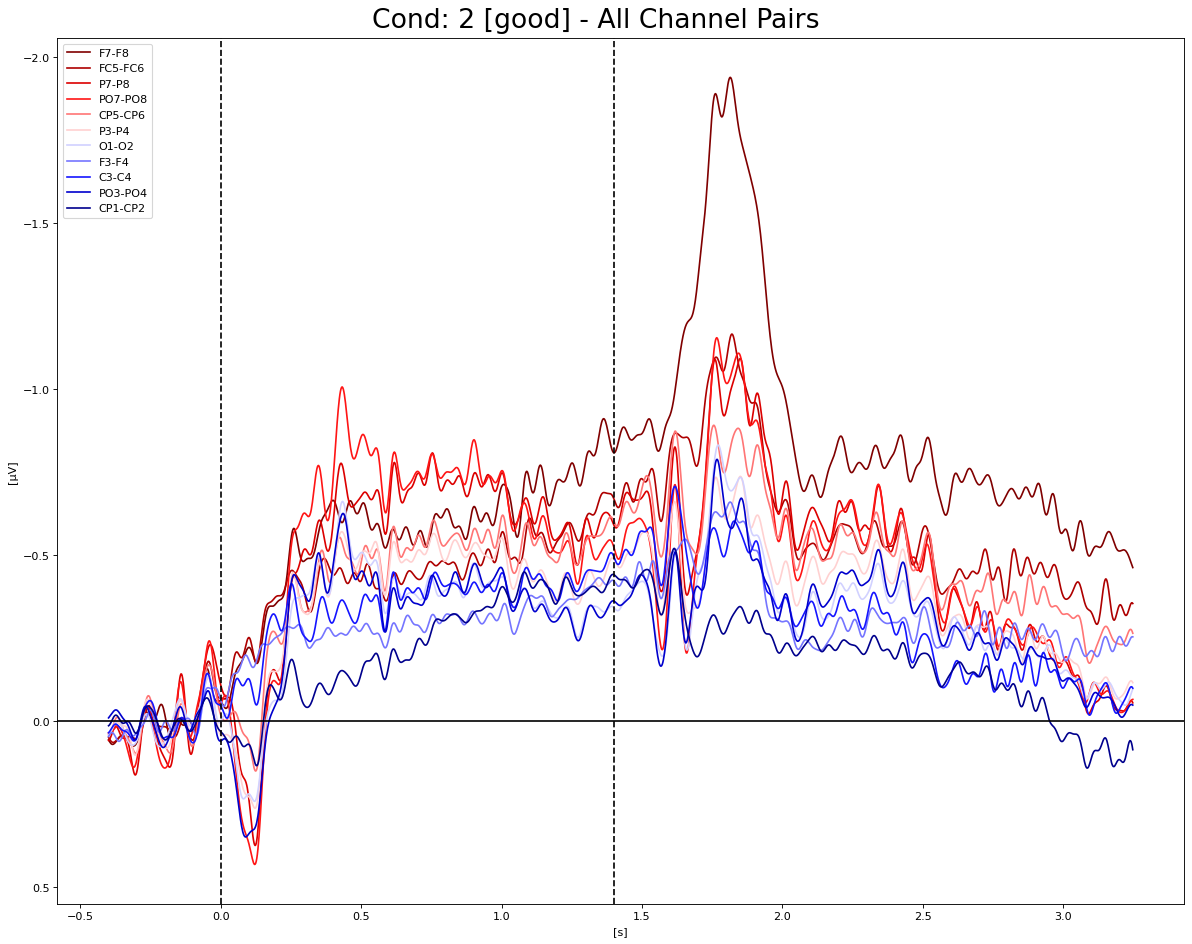

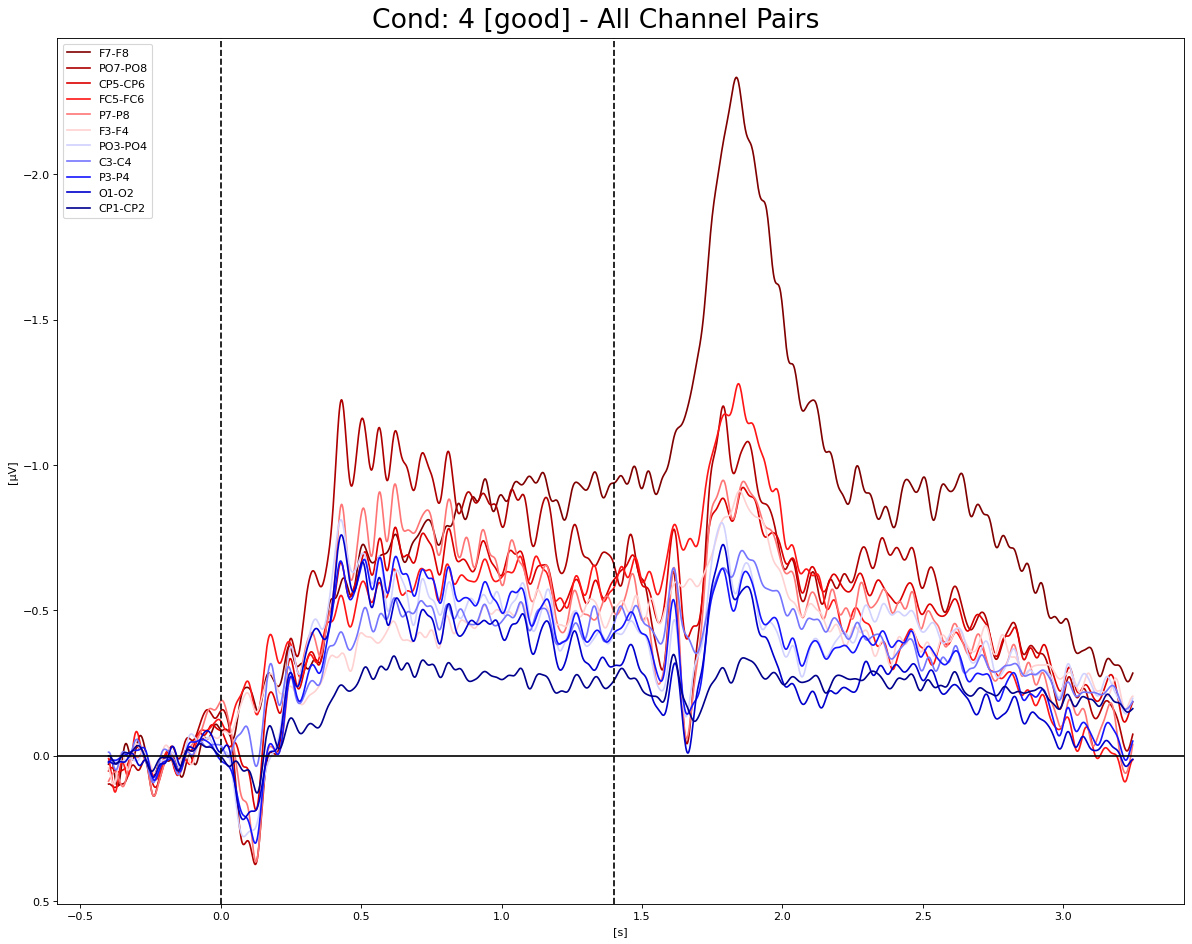

In [12]:
cmap = matplotlib.cm.get_cmap('seismic')

for perf in ['good']:
    for cond in conds:
        plt.figure(figsize=(15, 12), dpi=80)
        plt.suptitle("Cond: {} [{}] - All Channel Pairs".format(cond, perf), fontsize=24)

        if 'Fp1-Fp2' in cda_all_channels[cond][perf].keys():
            del cda_all_channels[cond][perf]['Fp1-Fp2']
        if 'FC1-FC2' in cda_all_channels[cond][perf].keys():
            del cda_all_channels[cond][perf]['FC1-FC2']
        
        ch_pair_mean_amp = [cda_all_channels[cond][perf][x].mean(0) for x in cda_all_channels[cond][perf]]
        mean_list, cda_sorted = zip(*sorted(zip(ch_pair_mean_amp, cda_all_channels[cond][perf].items()), reverse=True))

        nb_pairs = len(cda_all_channels[cond][perf].keys())
        for i, ch_pair in enumerate(cda_all_channels[cond][perf].keys()):
            plt.plot(times[times < 3.25], -1e6 * cda_sorted[i][1][times < 3.25], label=cda_sorted[i][0], color=cmap(1-i/nb_pairs))

        plt.axvline(x=0, color='k', linestyle='--')
        plt.axvline(x=1.4, color='k', linestyle='--')
        plt.axhline(y=0, color='k', linestyle='-')
        plt.gca().invert_yaxis()
        plt.ylabel('[μV]')
        plt.xlabel('[s]')
        plt.rcParams.update({'font.size': 10})
        plt.legend(loc=2)
        plt.tight_layout()
        plt.show()

#fig.savefig("./Balaban2019-RecallChannels_IntShape.png", dpi=300, format='png')

<Figure size 640x480 with 0 Axes>

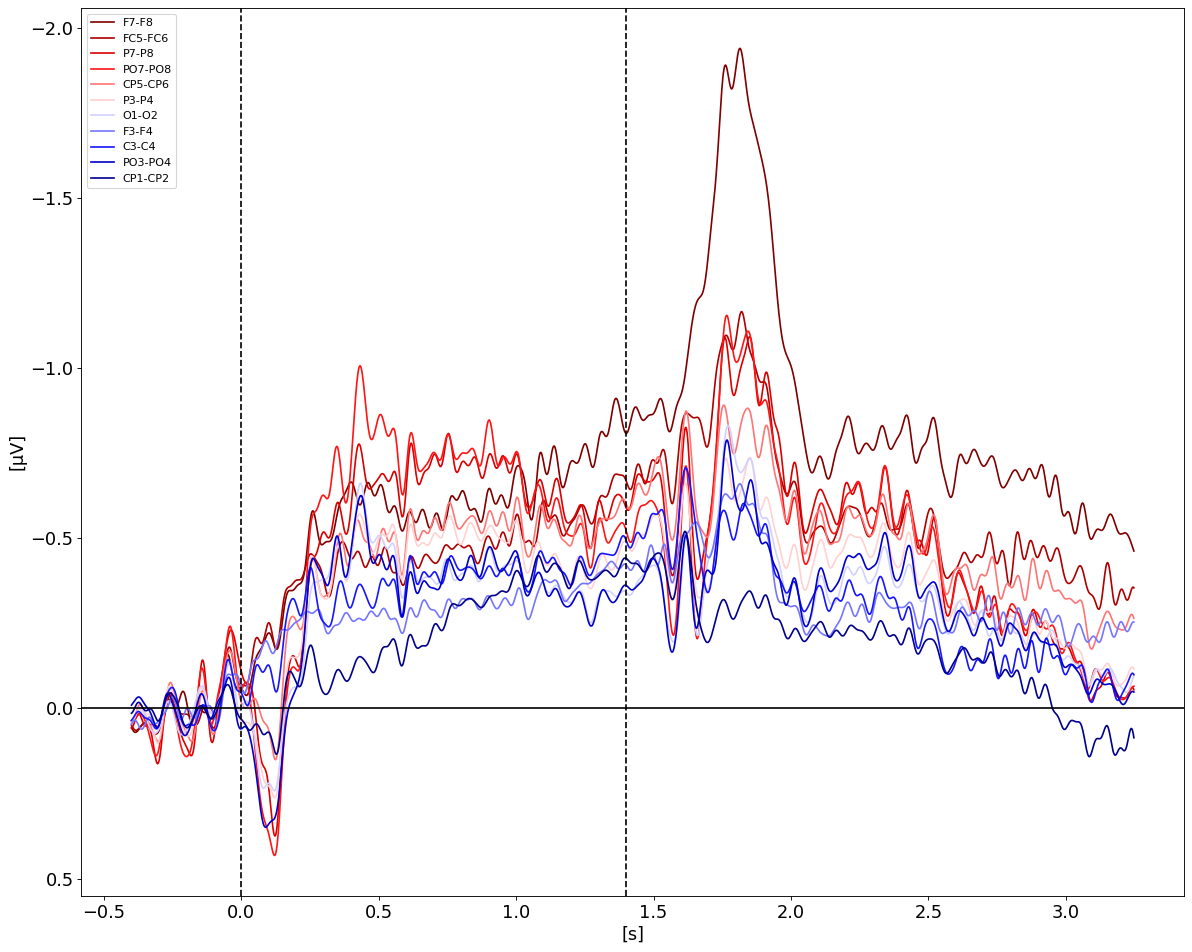

In [13]:
plt.rcParams.update({'font.size': 16})
cmap = matplotlib.cm.get_cmap('seismic')

perf = 'good'
cond = '2'

fig = plt.figure(figsize=(8, 6), dpi=80)
#plt.suptitle("CDA - All Channel Pairs", fontsize=20)

plt.figure(figsize=(15, 12), dpi=80)
#plt.suptitle("Cond: {} [{}] - All Channel Pairs".format(cond, perf), fontsize=24)

if 'Fp1-Fp2' in cda_all_channels[cond][perf].keys():
    del cda_all_channels[cond][perf]['Fp1-Fp2']
if 'FC1-FC2' in cda_all_channels[cond][perf].keys():
    del cda_all_channels[cond][perf]['FC1-FC2']

ch_pair_mean_amp = [cda_all_channels[cond][perf][x].mean(0) for x in cda_all_channels[cond][perf]]
mean_list, cda_sorted = zip(*sorted(zip(ch_pair_mean_amp, cda_all_channels[cond][perf].items()), reverse=True))

nb_pairs = len(cda_all_channels[cond][perf].keys())
for i, ch_pair in enumerate(cda_all_channels[cond][perf].keys()):
    plt.plot(times[times < 3.25], -1e6 * cda_sorted[i][1][times < 3.25], label=cda_sorted[i][0], color=cmap(1-i/nb_pairs))

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1.4, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.rcParams.update({'font.size': 10})
plt.legend(loc=2)
plt.tight_layout()
plt.show()

fig.savefig("./Hakim2019-RecallChannels_2.png", dpi=300, format='png')

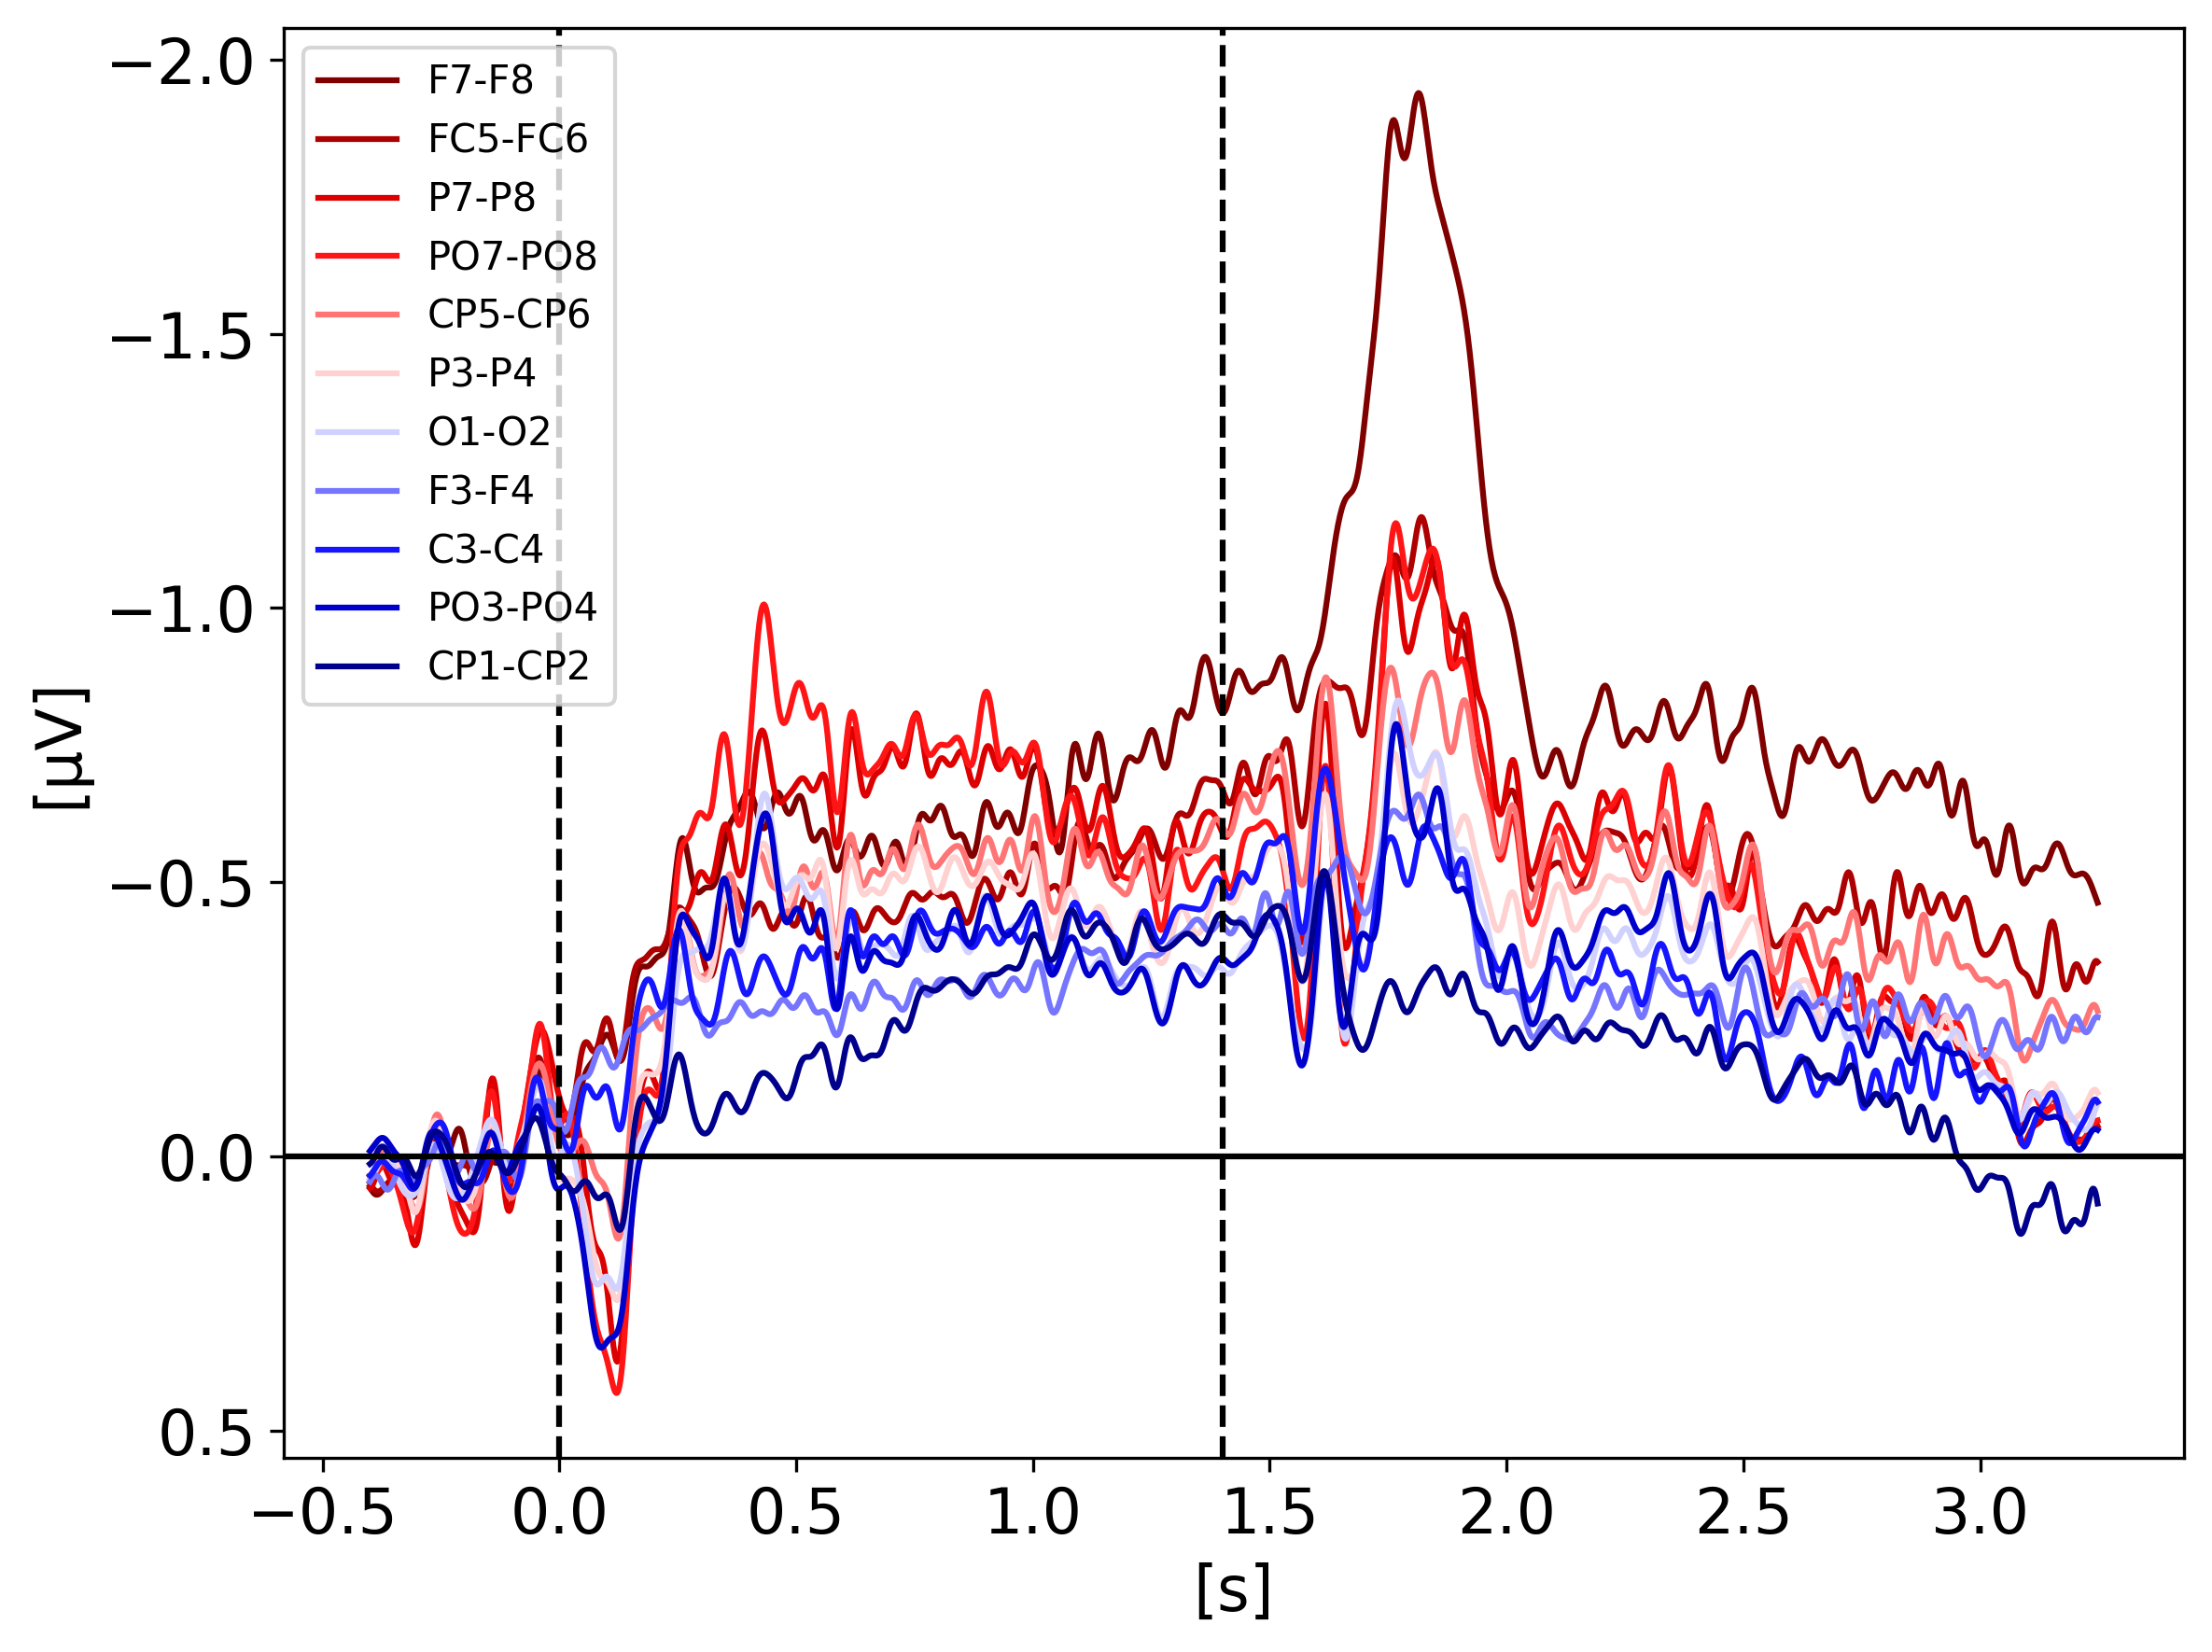

In [14]:
plt.rcParams.update({'font.size': 16})
cmap = matplotlib.cm.get_cmap('seismic')

perf = 'good'
cond = '2'

fig = plt.figure(figsize=(8, 6), dpi=300)
#plt.suptitle("CDA - All Channel Pairs", fontsize=20)

if 'Fp1-Fp2' in cda_all_channels[cond][perf].keys():
    del cda_all_channels[cond][perf]['Fp1-Fp2']
if 'FC1-FC2' in cda_all_channels[cond][perf].keys():
    del cda_all_channels[cond][perf]['FC1-FC2']

ch_pair_mean_amp = [cda_all_channels[cond][perf][x].mean(0) for x in cda_all_channels[cond][perf]]
mean_list, cda_sorted = zip(*sorted(zip(ch_pair_mean_amp, cda_all_channels[cond][perf].items()), reverse=True))

nb_pairs = len(cda_all_channels[cond][perf].keys())
for i, ch_pair in enumerate(cda_all_channels[cond][perf].keys()):
    plt.plot(times[times < 3.25], -1e6 * cda_sorted[i][1][times < 3.25], label=cda_sorted[i][0], color=cmap(1-i/nb_pairs))

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1.4, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.rcParams.update({'font.size': 10})
plt.legend(loc=2)
plt.tight_layout()
plt.show()

fig.savefig("./Hakim2019-RecallChannels_2.png", dpi=300, format='png')

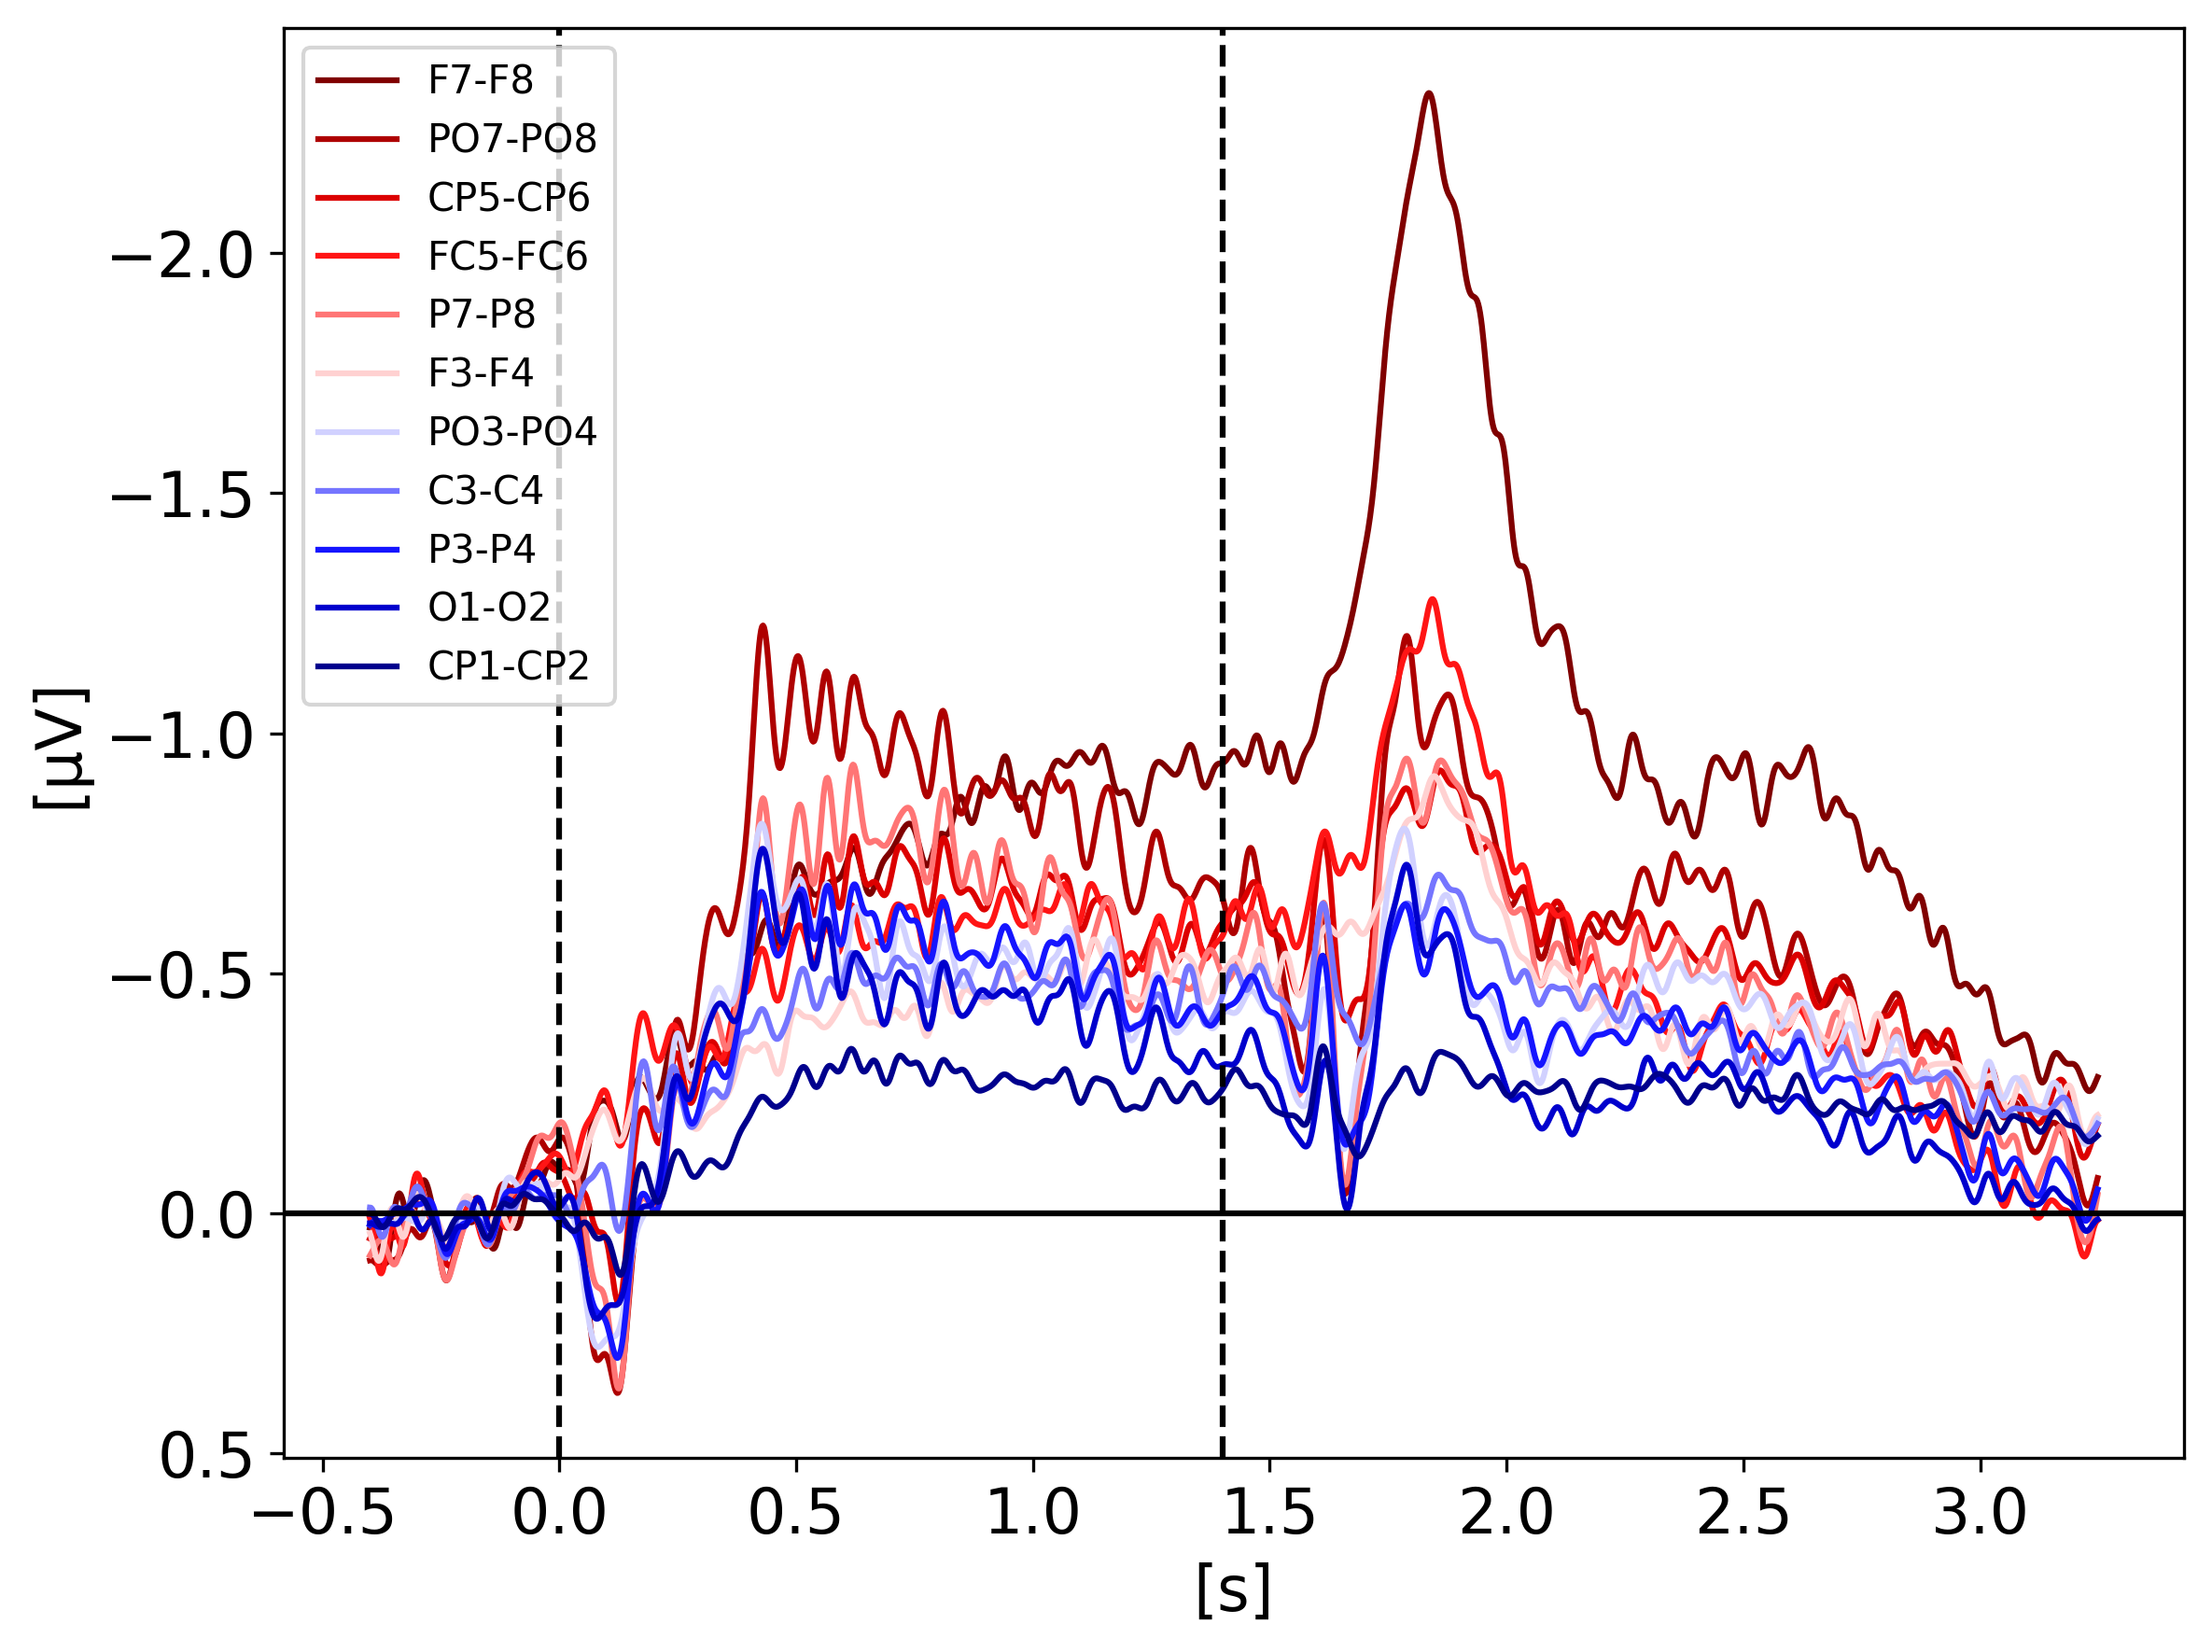

In [15]:
plt.rcParams.update({'font.size': 16})
cmap = matplotlib.cm.get_cmap('seismic')

perf = 'good'
cond = '4'

fig = plt.figure(figsize=(8, 6), dpi=300)
#plt.suptitle("CDA - All Channel Pairs", fontsize=20)

if 'Fp1-Fp2' in cda_all_channels[cond][perf].keys():
    del cda_all_channels[cond][perf]['Fp1-Fp2']
if 'FC1-FC2' in cda_all_channels[cond][perf].keys():
    del cda_all_channels[cond][perf]['FC1-FC2']

ch_pair_mean_amp = [cda_all_channels[cond][perf][x].mean(0) for x in cda_all_channels[cond][perf]]
mean_list, cda_sorted = zip(*sorted(zip(ch_pair_mean_amp, cda_all_channels[cond][perf].items()), reverse=True))

nb_pairs = len(cda_all_channels[cond][perf].keys())
for i, ch_pair in enumerate(cda_all_channels[cond][perf].keys()):
    plt.plot(times[times < 3.25], -1e6 * cda_sorted[i][1][times < 3.25], label=cda_sorted[i][0], color=cmap(1-i/nb_pairs))

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1.4, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.rcParams.update({'font.size': 10})
plt.legend(loc=2)
plt.tight_layout()
plt.show()

fig.savefig("./Hakim2019-RecallChannels_4.png", dpi=300, format='png')